In [1]:
import pandas as pd
import numpy as np

# Normalizes data into a range (0 to 1) for faster and stable training.
from sklearn.preprocessing import MinMaxScaler

# Keras components for building and training the neural network.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [4]:
# Load the data
file_path = 'weather_data_goa_hourly.csv'
weather_data = pd.read_csv(file_path)

In [5]:
# PREPROCESSING OF DATA **************************************************************************************************************************

# Converts the date_time column into a datetime object for easier date-time-based feature extraction.
weather_data['date_time'] = pd.to_datetime(weather_data['date_time'])

# Extracts hour and day_of_week from the timestamp to capture periodic trends.
weather_data['hour'] = weather_data['date_time'].dt.hour
weather_data['day_of_week'] = weather_data['date_time'].dt.dayofweek

# tempC_lag1 creates a lag feature/column (temperature from the previous hour).
weather_data['tempC_lag1'] = weather_data['tempC'].shift(1)

# dropna() removes rows with missing values (caused by the lag feature).
weather_data.dropna(inplace=True)

# Select features and normalize to the range of (0,1)
features = ['tempC', 'humidity', 'pressure', 'precipMM', 'uvIndex', 'windspeedKmph', 'winddirDegree', 'tempC_lag1', 'hour', 'day_of_week']
scaler = MinMaxScaler()
weather_data[features] = scaler.fit_transform(weather_data[features])

In [6]:
# SEQUENCE PREPARATION FOR LSTM ******************************************************************************************************************

# Prepare the data for LSTM (LSTMs require sequential input data for time series prediction)

sequence_length = 24  # Use the last 24 hours to predict the next hour
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]   # features for the past 24 hours
        y = data[i+seq_length][0]  # Predict the temperature for next hour
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Split into sequences
X, y = create_sequences(weather_data[features].values, sequence_length)

# Splits data into training (80%) and validation (20%) sets.
split_idx = int(0.8 * len(X))
X_train, y_train = X[:split_idx], y[:split_idx]
X_val, y_val = X[split_idx:], y[split_idx:]

In [7]:
# BUILDING THE LSTM MODEL ******************************************************************************************************************

# A stacked LSTM model is built
# First LSTM layer: 50 neurons , return sequences of output
# Dropout layers: Prevent overfitting by randomly deactivating 20 % neurons during training.
# Dense layers: Perform the final computation to predict temperature.

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, len(features))),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# adam - adjusts weights during training
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 99s 26ms/step - loss: 0.0053 - val_loss: 5.6122e-04
Epoch 2/20
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 141s 25ms/step - loss: 6.4757e-04 - val_loss: 2.5065e-04
Epoch 3/20
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 144s 26ms/step - loss: 4.6666e-04 - val_loss: 1.7663e-04
Epoch 4/20
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 144s 27ms/step - loss: 4.0057e-04 - val_loss: 2.5648e-04
Epoch 5/20
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 98s 27ms/step - loss: 3.7651e-04 - val_loss: 1.9611e-04
Epoch 6/20
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 138s 26ms/step - loss: 3.7247e-04 - val_loss: 1.8541e-04
Epoch 7/20
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 141s 26ms/step - loss: 3.6525e-04 - val_loss: 2.6220e-04
Epoch 8/20
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 142s 26ms/step - loss: 3.6472e-04 - val_loss: 1.8991e-04
Epoch 9/20
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 93s 26ms/step - loss: 3.4537e-04 - val_loss: 1.5394e-04
Epoch 10/20
3607/3607 ━━━━━━━━━━━━━━━━━━━━ 142s 26ms/step - loss: 3.4021e-04 - val_loss: 1.6125e-04
Epoch 11/20
3607

In [8]:
# PREDICTING FUTURE TEMPERATURES ***************************************************************************************************************

# Update the future_dates cover only from 16th January 2025 to the end of January 2025
future_dates = pd.date_range(start='2025-01-16', end='2025-01-31', freq='H')
predictions = []

# Use the last sequence from the dataset for prediction
last_sequence = weather_data[features].values[-sequence_length:]

for date in future_dates:

    print(f"Predicting for {date}")

    # Predict the next temperature using the LSTM model
    next_prediction = model.predict(last_sequence[np.newaxis, :, :])

    # Reshape next_prediction to ensure it is a 1D array
    next_prediction = next_prediction.flatten()

    if np.isnan(next_prediction).any():
        print(f"NaN encountered at {date}, stopping prediction.")
        break

    # Update the last sequence with the new prediction
    last_sequence = np.vstack([last_sequence[1:], np.hstack([next_prediction, last_sequence[-1, 1:]])])

    # Append the prediction for the specific date
    predictions.append(next_prediction)

# Check if predictions are non-empty before proceeding
if predictions:
    # Converts normalized predictions back to the original scale using scaler.inverse_transform.
    predictions_array = np.array(predictions).reshape(-1, 1)
    transformed_predictions = scaler.inverse_transform(np.hstack([predictions_array, np.zeros((len(predictions_array), len(features)-1))]))[:, 0]

    # Prepare the results
    df_predictions = pd.DataFrame({'date_time': future_dates, 'predicted_tempC': transformed_predictions})
    print(df_predictions.head())
else:
    print("No predictions were made.")

<ipython-input-8-305f4241a389>:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start='2025-01-16', end='2025-01-31', freq='H')


Predicting for 2025-01-16 00:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step
Predicting for 2025-01-16 01:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicting for 2025-01-16 02:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicting for 2025-01-16 03:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicting for 2025-01-16 04:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicting for 2025-01-16 05:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicting for 2025-01-16 06:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicting for 2025-01-16 07:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicting for 2025-01-16 08:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicting for 2025-01-16 09:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicting for 2025-01-16 10:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicting for 2025-01-16 11:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicting for 2025-01-16 12:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicting for 2025-01-16 13:00:00
1/1 ━━━━━━━━━━━

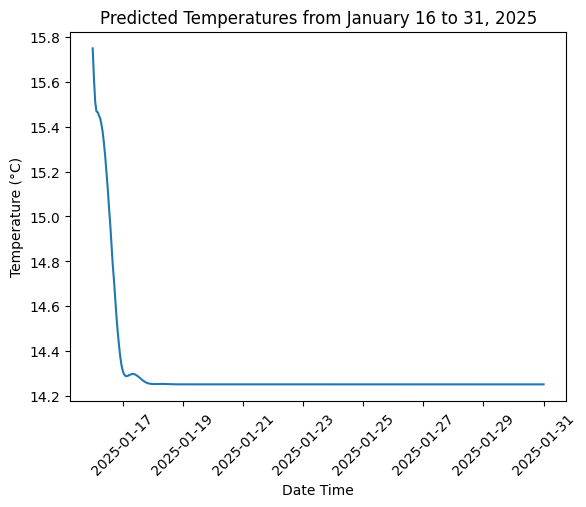

In [9]:
# Plotting Graphs

import matplotlib.pyplot as plt

plt.plot(df_predictions['date_time'], df_predictions['predicted_tempC'])
plt.title('Predicted Temperatures from January 16 to 31, 2025')
plt.xlabel('Date Time')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.show()